In [1]:
from keras.layers import Dense, Conv2D, Flatten, LeakyReLU, Reshape, BatchNormalization, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam

In [2]:
((trainx, trainy), (testx, testy)) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
trainx =  trainx.reshape(-1, 28, 28, 1).astype('float')
print(trainx.shape, testy.shape)

(60000, 28, 28, 1) (10000,)


In [4]:
mean = 127.5
std = 127.5

trainx = (trainx - mean) / std

In [5]:
TOTAL_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = int(trainx.shape[0] / float(BATCH_SIZE))
HALF_BATCH = 128

NOISE_DIM = 100
ADAM = Adam(learning_rate=2e-4, beta_1=0.5)

# Create Generator

In [6]:
generator = Sequential()
generator.add(Dense(7*7*128, input_shape=(NOISE_DIM,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# upsampling 14x14x64
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=(5,5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# upsampling 28x28x1
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=(5,5), padding='same', activation='tanh'))

generator.compile(loss='binary_crossentropy', optimizer='adam')
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        2

# Create Discriminator

In [7]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2,2), padding='same', input_shape=(28,28,1)))
discriminator.add(LeakyReLU(0.2))
# will create conv layer (14x14x64)

discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(0.2))
# will create conv layer (7x7x128)

discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212865 (831.50 KB)
Trainable params: 212

In [8]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

model = Model(gan_input, gan_output)
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         840705    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1053570 (4.02 MB)
Trainable params: 840321 (3.21 MB)
Non-trainable params: 213249 (833.00 KB)
_________________________________________________________________


In [9]:
!mkdir images gan_model

In [10]:
def save_imgs(epoch, samples=100):

  noise = np.random.normal(0, 1, size=(samples, NOISE_DIM))
  generated_imgs = generator.predict(noise)
  generated_imgs = generated_imgs.reshape(samples, 28, 28)

  plt.figure(figsize=(10,10))
  for i in range(samples):
    plt.subplot(10, 10, i + 1)
    plt.imshow(generated_imgs[i], cmap='gray', interpolation='nearest')
    plt.axis('off')

  plt.tight_layout()
  plt.savefig('images/gen_output_epoch_{0}.png'.format(epoch + 1))
  plt.show()

4/4 [==============================] - 0s 3ms/step
Epoch: 0, Discriminator Loss: 0.4389, Generator Loss: 2.2412
4/4 [==============================] - 0s 3ms/step
Epoch: 1, Discriminator Loss: 0.3375, Generator Loss: 2.9237
4/4 [==============================] - 0s 3ms/step
Epoch: 2, Discriminator Loss: 0.3949, Generator Loss: 2.5986
4/4 [==============================] - 0s 3ms/step
Epoch: 3, Discriminator Loss: 0.3718, Generator Loss: 2.5429
4/4 [==============================] - 0s 3ms/step
Epoch: 4, Discriminator Loss: 0.3551, Generator Loss: 2.7683
1/4 [======>.......................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 56ms/step


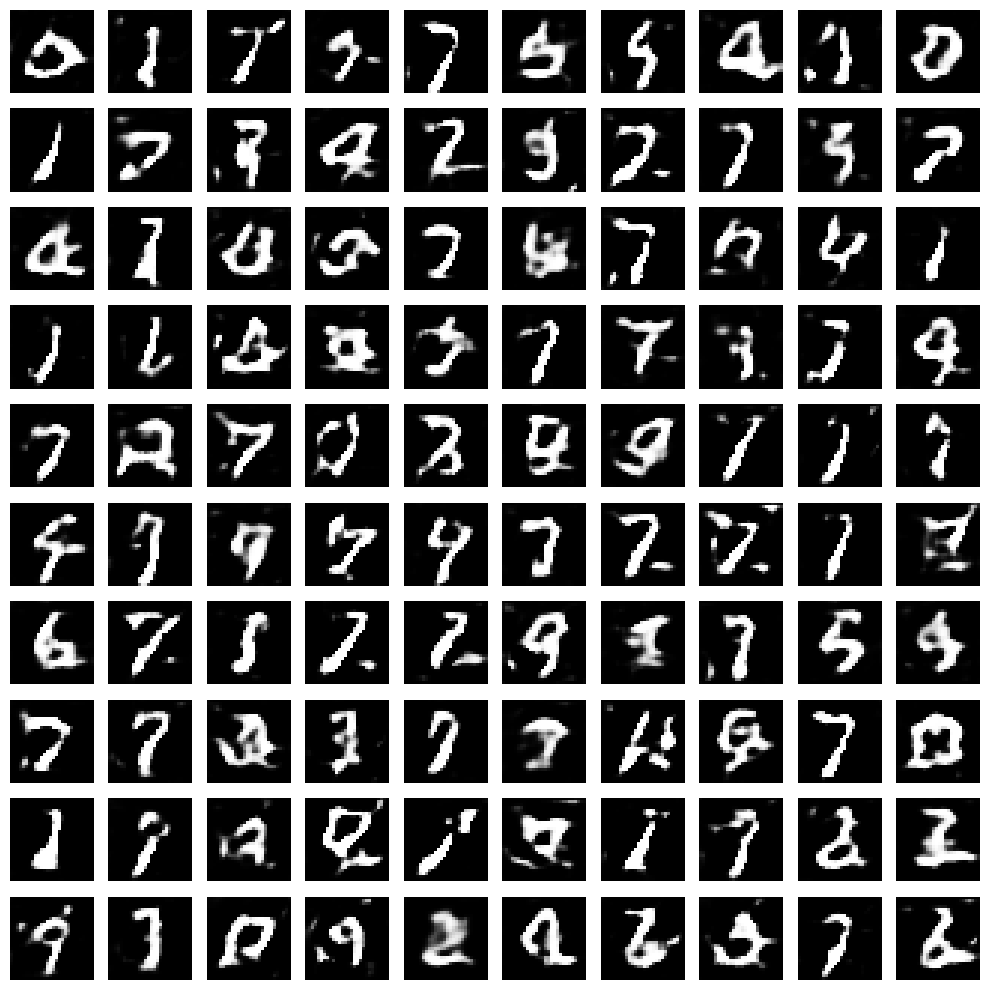

4/4 [==============================] - 0s 3ms/step
Epoch: 5, Discriminator Loss: 0.3807, Generator Loss: 2.7511
4/4 [==============================] - 0s 3ms/step
Epoch: 6, Discriminator Loss: 0.4157, Generator Loss: 2.5078
4/4 [==============================] - 0s 3ms/step
Epoch: 7, Discriminator Loss: 0.4256, Generator Loss: 2.3948
4/4 [==============================] - 0s 5ms/step
Epoch: 8, Discriminator Loss: 0.4118, Generator Loss: 2.5511
4/4 [==============================] - 0s 3ms/step
Epoch: 9, Discriminator Loss: 0.4351, Generator Loss: 2.2401
4/4 [==============================] - 0s 4ms/step


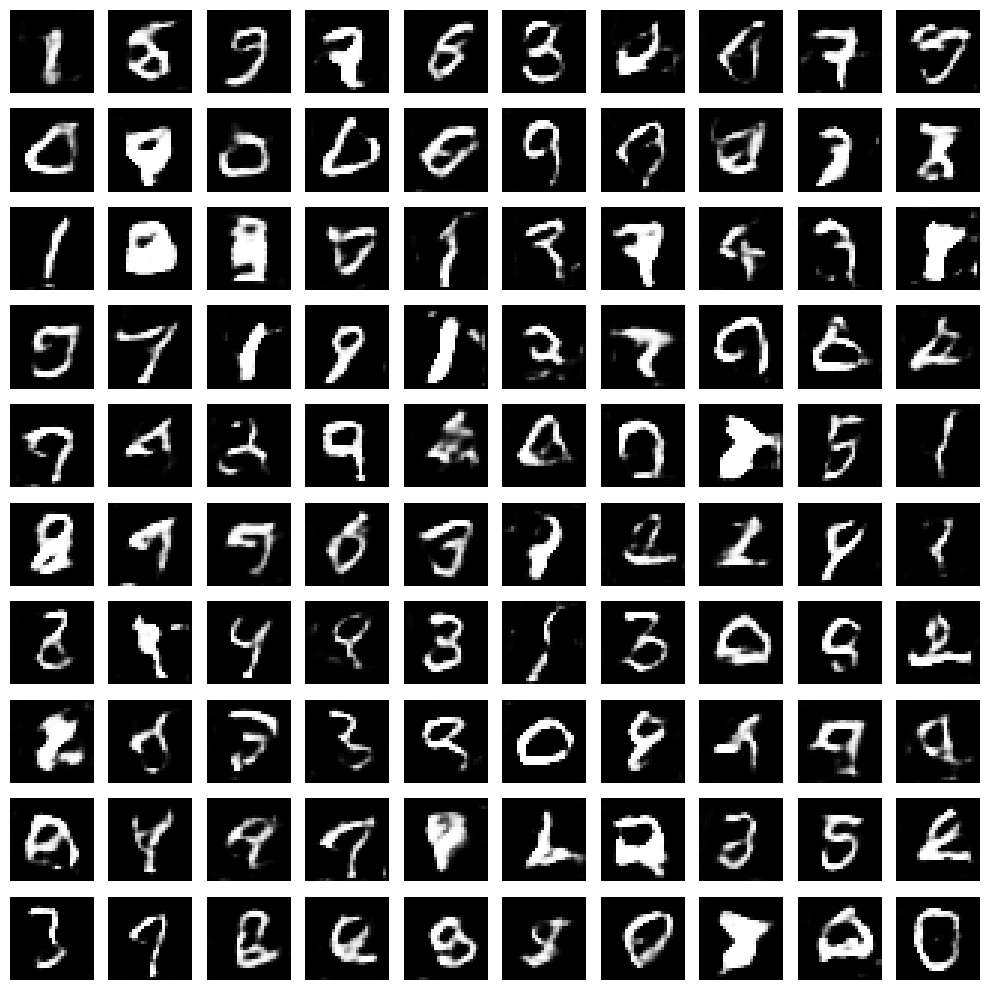

4/4 [==============================] - 0s 3ms/step
Epoch: 10, Discriminator Loss: 0.4326, Generator Loss: 2.2596
4/4 [==============================] - 0s 6ms/step
Epoch: 11, Discriminator Loss: 0.4159, Generator Loss: 2.4197
4/4 [==============================] - 0s 3ms/step
Epoch: 12, Discriminator Loss: 0.4280, Generator Loss: 2.3179
4/4 [==============================] - 0s 7ms/step
Epoch: 13, Discriminator Loss: 0.4072, Generator Loss: 2.5434
4/4 [==============================] - 0s 3ms/step
Epoch: 14, Discriminator Loss: 0.4053, Generator Loss: 2.5623
4/4 [==============================] - 0s 4ms/step


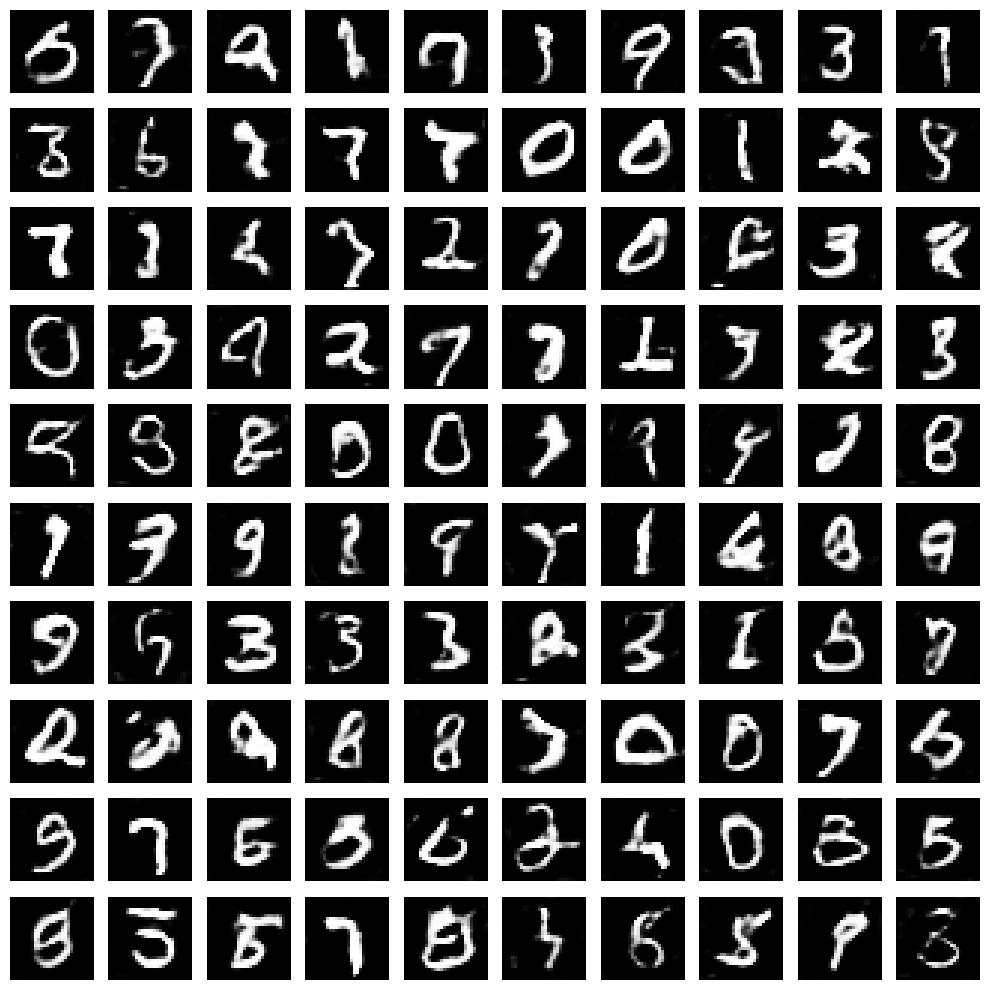

4/4 [==============================] - 0s 3ms/step
Epoch: 15, Discriminator Loss: 0.4087, Generator Loss: 2.5619
4/4 [==============================] - 0s 3ms/step
Epoch: 16, Discriminator Loss: 0.4052, Generator Loss: 2.5041
4/4 [==============================] - 0s 3ms/step
Epoch: 17, Discriminator Loss: 0.4086, Generator Loss: 2.5261
4/4 [==============================] - 0s 3ms/step
Epoch: 18, Discriminator Loss: 0.4051, Generator Loss: 2.5069
4/4 [==============================] - 0s 3ms/step
Epoch: 19, Discriminator Loss: 0.4013, Generator Loss: 2.5790
4/4 [==============================] - 0s 3ms/step


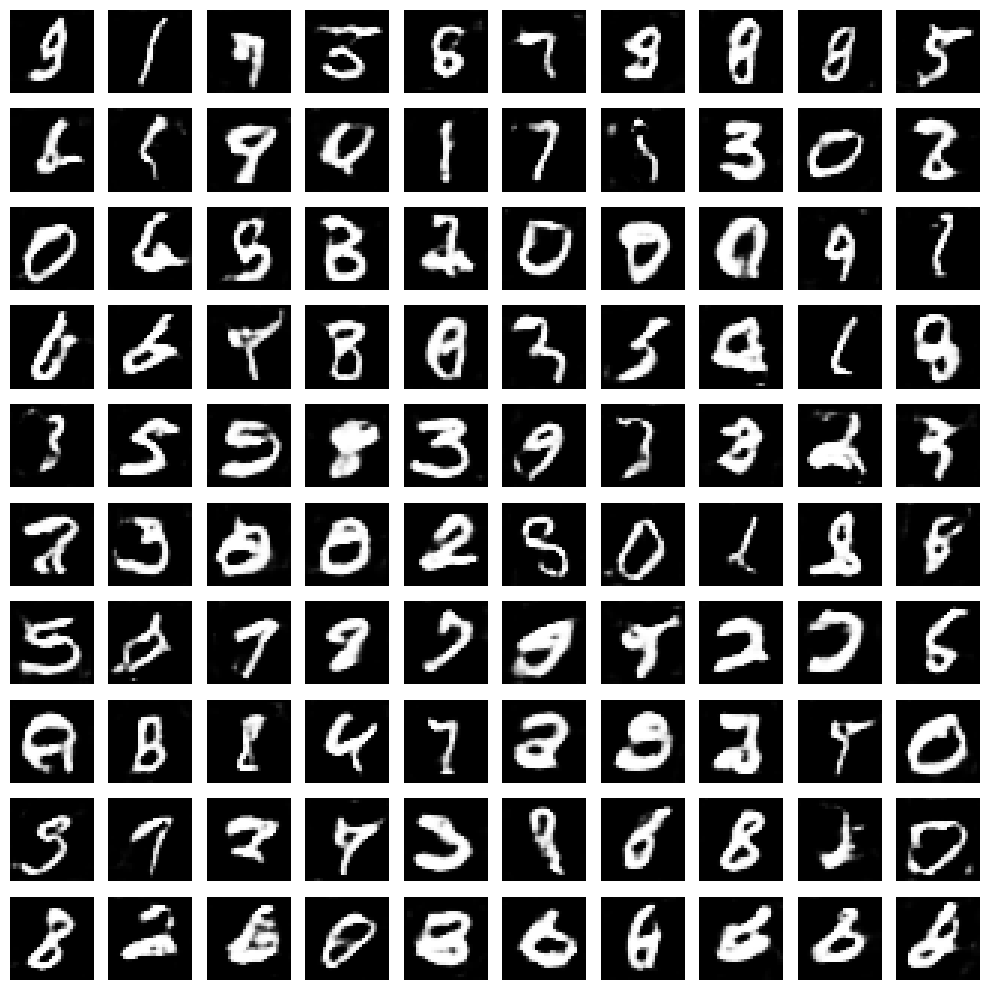

4/4 [==============================] - 0s 3ms/step
Epoch: 20, Discriminator Loss: 0.4064, Generator Loss: 2.5549
4/4 [==============================] - 0s 3ms/step
Epoch: 21, Discriminator Loss: 0.3988, Generator Loss: 2.6089
4/4 [==============================] - 0s 3ms/step
Epoch: 22, Discriminator Loss: 0.4069, Generator Loss: 2.5015
4/4 [==============================] - 0s 3ms/step
Epoch: 23, Discriminator Loss: 0.4112, Generator Loss: 2.5286
4/4 [==============================] - 0s 3ms/step
Epoch: 24, Discriminator Loss: 0.4001, Generator Loss: 2.5741
4/4 [==============================] - 0s 3ms/step


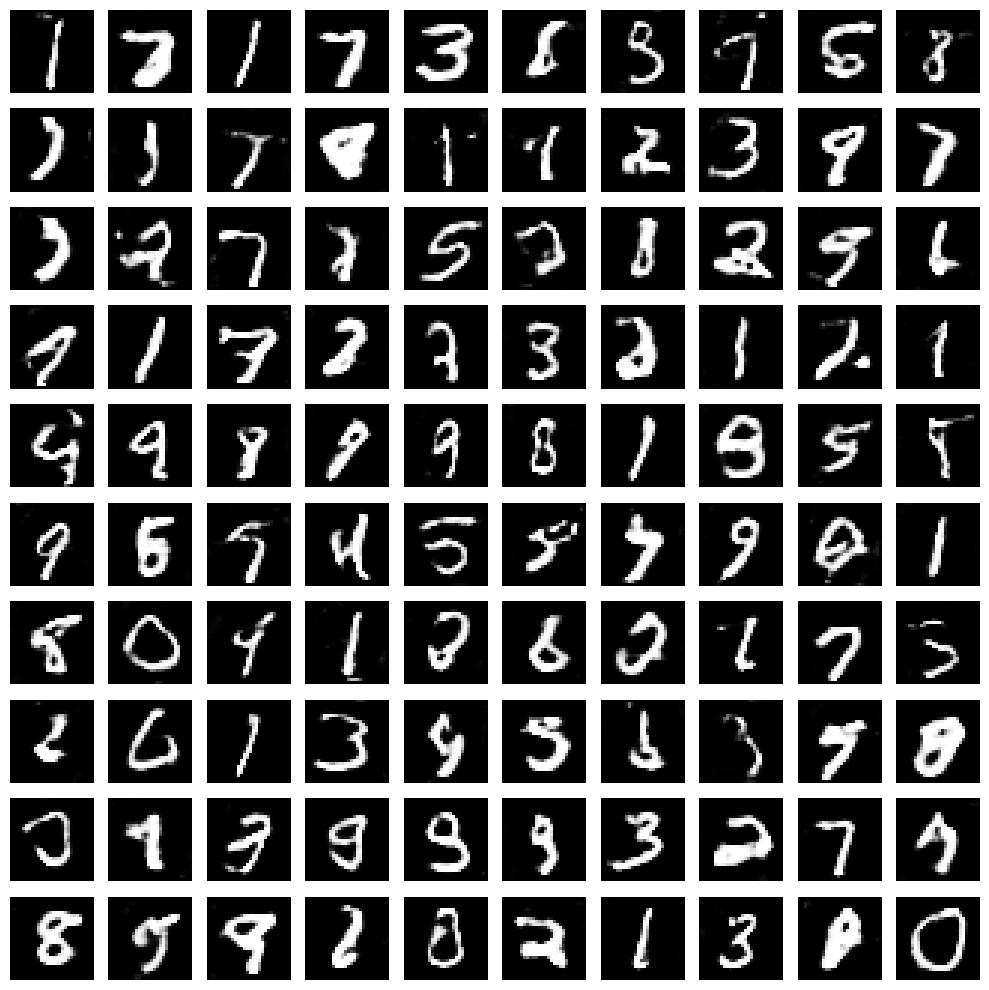

4/4 [==============================] - 0s 3ms/step
Epoch: 25, Discriminator Loss: 0.3972, Generator Loss: 2.6515
4/4 [==============================] - 0s 3ms/step
Epoch: 26, Discriminator Loss: 0.3995, Generator Loss: 2.5770
4/4 [==============================] - 0s 3ms/step
Epoch: 27, Discriminator Loss: 0.3985, Generator Loss: 2.6157
4/4 [==============================] - 0s 3ms/step
Epoch: 28, Discriminator Loss: 0.3984, Generator Loss: 2.6345
4/4 [==============================] - 0s 3ms/step
Epoch: 29, Discriminator Loss: 0.3936, Generator Loss: 2.6848
4/4 [==============================] - 0s 3ms/step


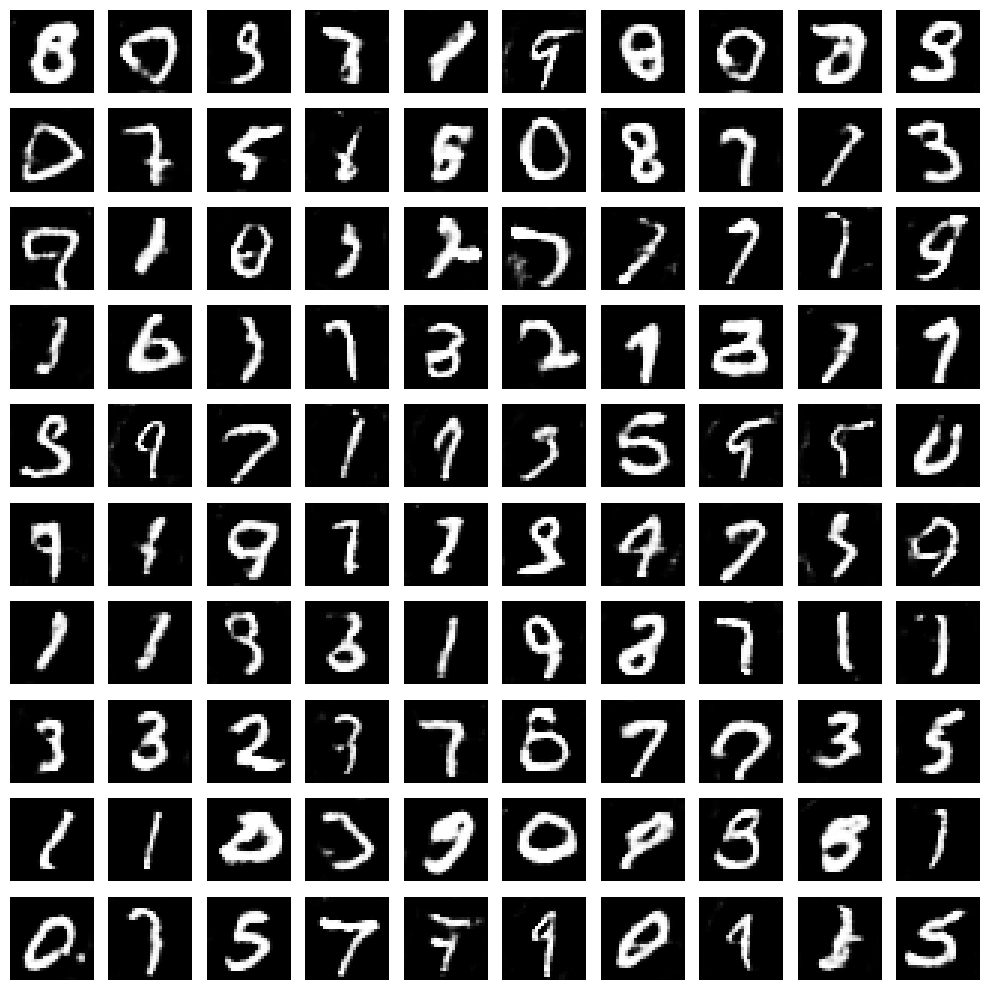

4/4 [==============================] - 0s 3ms/step
Epoch: 30, Discriminator Loss: 0.3884, Generator Loss: 2.7513
4/4 [==============================] - 0s 3ms/step
Epoch: 31, Discriminator Loss: 0.3896, Generator Loss: 2.7163
4/4 [==============================] - 0s 3ms/step
Epoch: 32, Discriminator Loss: 0.3929, Generator Loss: 2.6734
4/4 [==============================] - 0s 3ms/step
Epoch: 33, Discriminator Loss: 0.3881, Generator Loss: 2.7680
4/4 [==============================] - 0s 3ms/step
Epoch: 34, Discriminator Loss: 0.3848, Generator Loss: 2.7222
4/4 [==============================] - 0s 3ms/step


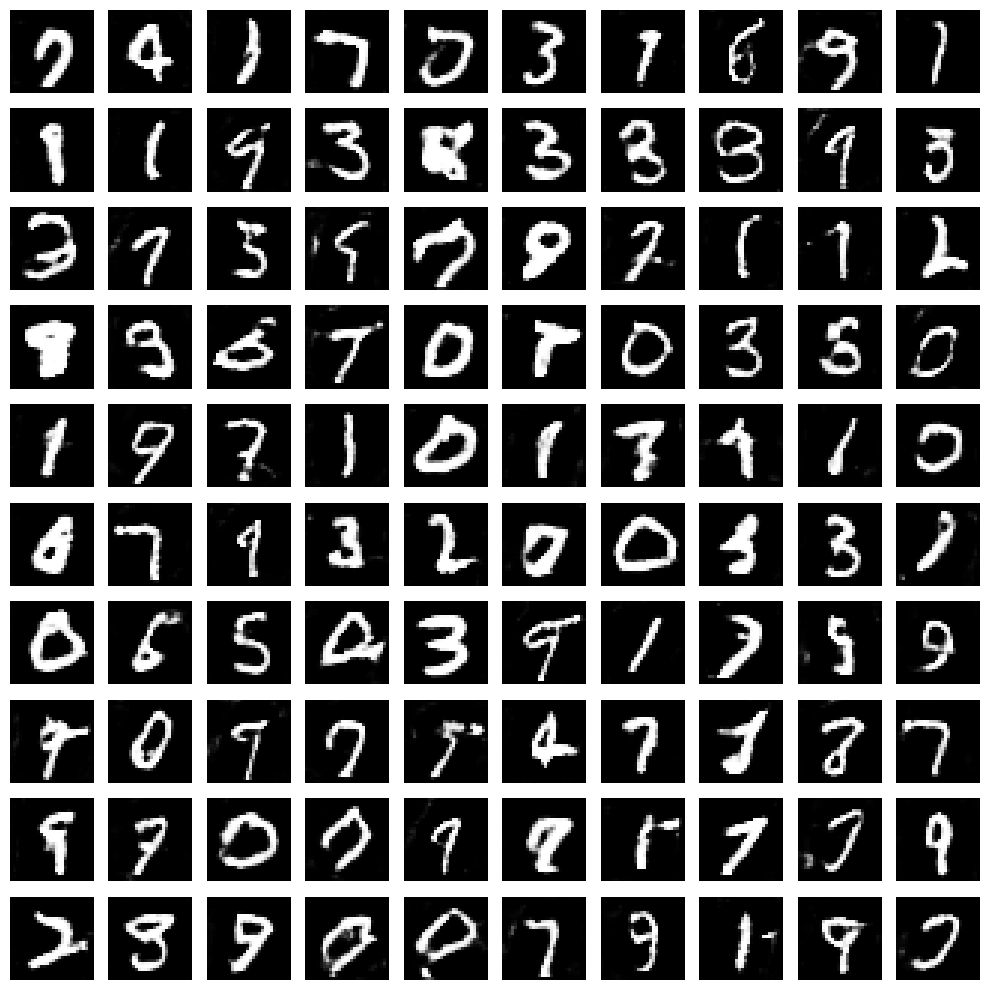

4/4 [==============================] - 0s 3ms/step
Epoch: 35, Discriminator Loss: 0.3885, Generator Loss: 2.7841
4/4 [==============================] - 0s 3ms/step
Epoch: 36, Discriminator Loss: 0.3777, Generator Loss: 2.8056
4/4 [==============================] - 0s 3ms/step
Epoch: 37, Discriminator Loss: 0.3796, Generator Loss: 2.8842
4/4 [==============================] - 0s 3ms/step
Epoch: 38, Discriminator Loss: 0.3861, Generator Loss: 2.7837
4/4 [==============================] - 0s 4ms/step
Epoch: 39, Discriminator Loss: 0.3669, Generator Loss: 2.9443
4/4 [==============================] - 0s 3ms/step


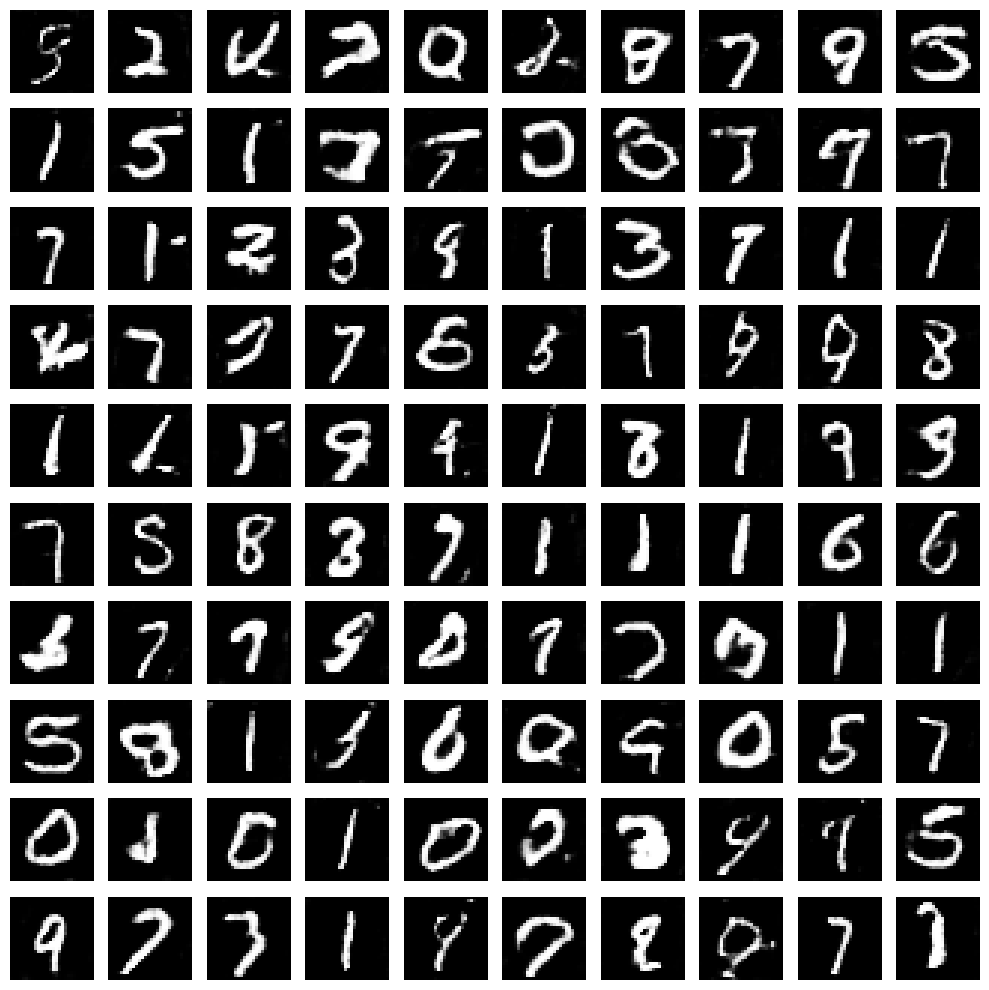

4/4 [==============================] - 0s 3ms/step
Epoch: 40, Discriminator Loss: 0.3819, Generator Loss: 2.8248
4/4 [==============================] - 0s 4ms/step
Epoch: 42, Discriminator Loss: 0.3735, Generator Loss: 2.8956
4/4 [==============================] - 0s 3ms/step
Epoch: 43, Discriminator Loss: 0.3671, Generator Loss: 2.9203
4/4 [==============================] - 0s 3ms/step
Epoch: 44, Discriminator Loss: 0.3672, Generator Loss: 2.9176
4/4 [==============================] - 0s 3ms/step


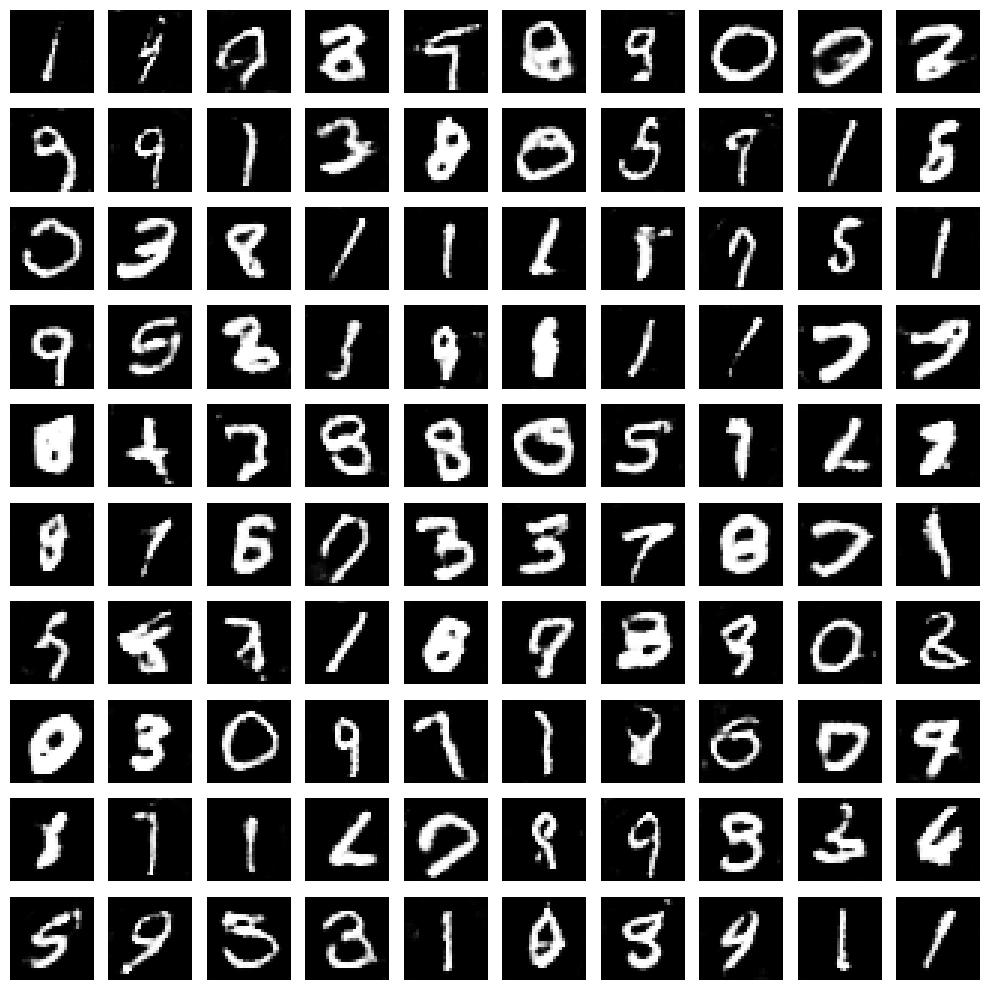

4/4 [==============================] - 0s 3ms/step
Epoch: 45, Discriminator Loss: 0.3604, Generator Loss: 3.0327
4/4 [==============================] - 0s 6ms/step
Epoch: 46, Discriminator Loss: 0.3711, Generator Loss: 2.9685
4/4 [==============================] - 0s 3ms/step
Epoch: 47, Discriminator Loss: 0.3625, Generator Loss: 2.9390
4/4 [==============================] - 0s 3ms/step
Epoch: 48, Discriminator Loss: 0.3652, Generator Loss: 3.0067
4/4 [==============================] - 0s 3ms/step
Epoch: 49, Discriminator Loss: 0.3610, Generator Loss: 2.9786
4/4 [==============================] - 0s 3ms/step


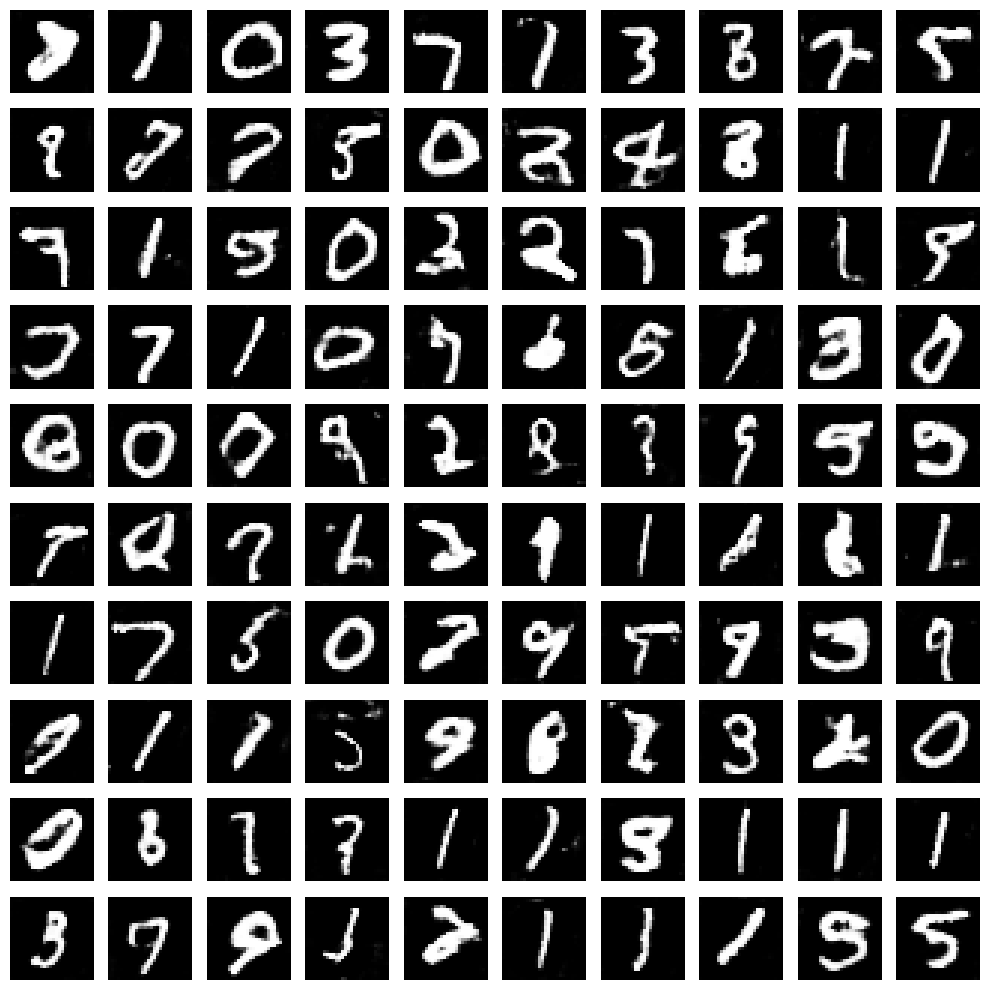

In [11]:
# Training Loop
for epoch in range(TOTAL_EPOCHS):
  epoch_d_loss = 0.0
  epoch_g_loss = 0.0

  for step in range(NO_OF_BATCHES):
    # step-1 Discriminator
    # 50% Real Data + Fake Data

    # Real Data
    idx = np.random.randint(0, trainx.shape[0], HALF_BATCH)
    real_imgs = trainx[idx]

    # Fake Data
    noise = np.random.normal(0, 1, size=(HALF_BATCH, NOISE_DIM))
    fake_imgs = generator.predict(noise) # Forward

    # create labels for fake and real
    real_y = np.ones((HALF_BATCH, 1))*0.9
    fake_y = np.zeros((HALF_BATCH, 1))

    # Train our discriminator
    d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
    d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)
    d_loss = 0.5 * d_loss_real + 0.5 * d_loss_fake
    epoch_d_loss += d_loss

    # step-2 Train Generator(Considering Frozen Discriminator)
    noise = np.random.normal(0, 1, size=(BATCH_SIZE, NOISE_DIM))
    ground_truth_y = np.ones((BATCH_SIZE, 1))
    g_loss = model.train_on_batch(noise, ground_truth_y)
    epoch_g_loss += g_loss

  print('Epoch: %d, Discriminator Loss: %.4f, Generator Loss: %.4f'%(epoch, epoch_d_loss/NO_OF_BATCHES, epoch_g_loss/NO_OF_BATCHES))

  if (epoch + 1) % 5 == 0:
    generator.save('gan_model/generator_'+f'{epoch + 1}'+'.h5')
    save_imgs(epoch)

In [ ]:
!zip -r /content/images.zip /content/images
from google.colab import files
files.download('images.zip')